# Проект по А/B-тестированию

## Постановка задачи
Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов. 

Оцените корректность проведения теста и проанализируйте его результаты. Чтобы оценить корректность проведения теста:
* удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
* проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.


Подробнее об этом мы рассказываем в разделе «Как выполнить задание» в конце урока.

## Техническое задание
* Название теста: `recommender_system_test` ;
* Группы: `А (контрольная)`, `B (новая платёжная воронка)`;
* Дата запуска: `2020-12-07`;
* Дата остановки набора новых пользователей: `2020-12-21`;
* Дата остановки: `2021-01-04`;
* Ожидаемое количество участников теста: `15% `новых пользователей из региона `EU`;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемый эффект: за `14 дней` с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на `5 процентных пунктов`:
    * конверсии в просмотр карточек товаров — событие `product_page`
    * просмотры корзины — `product_cart`
    * покупки — `purchase`.

## Описание данных

`/datasets/ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год; Структура файла:
* `name` — название маркетингового события;
* `regions` — регионы, в которых будет проводиться рекламная кампания;
* `start_dt` — дата начала кампании;
* `finish_dt` — дата завершения кампании.


`/datasets/final_ab_new_users.csv` — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года; Структура файла:
- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.


`/datasets/final_ab_events.csv` — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года; Структура файла:
- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, purchase , в этом поле хранится стоимость покупки в долларах.

`/datasets/final_ab_participants.csv` — таблица участников тестов. Структура файла:
- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Декомпозиция

Цели исследования - провести оценку результатов A/B-теста. Чтобы оценить корректность проведения теста:

- удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;
- проверьте равномерность распределения пользователей по тестовым группам и правильность их формирования.

1) Загрузка и знакомство с данными

2. Предобработка данных
* 1) Преобразование типов данных
* 2) Пропуски


3) Оцените корректность проведения теста
* 1) Проверка на соответствие данных требованиям технического задания. 
* 2) Проверка времени проведения теста. (Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.)
* 3) Проверка на аудиторию теста (Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.)

4) Исследовательский анализ данных
- 1) Количество событий на пользователя одинаково распределены в выборках?
- 2) Как число событий в выборках распределено по дням?
- 3) Как меняется конверсия в воронке в выборках на разных этапах?



5) Оцените результаты A/B-тестирования
- 1) Что можно сказать про результаты A/В-тестирования?
- 2) Проверьте статистическую разницу долей z-критерием.


6) Опишите выводы по этапу исследовательского анализа данных и по проведённой оценке результатов A/B-тестирования. Сделайте общее заключение о корректности проведения теста.

## Импорт библиотек и настроек

In [1]:
import warnings
warnings.simplefilter('ignore')


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from pylab import rcParams
import math as mth
import scipy.stats as st


%config InlineBackend.figure_format = 'svg'
sns.set_theme(style='whitegrid')


pd.set_option("display.max_rows", None)
pd.set_option('display.max_colwidth', 0)
pd.options.display.float_format = '{:.2f}'.format


%matplotlib inline
rcParams['figure.figsize'] =10, 5

## Шаг 1. Загрузка и знакомство с данными

In [2]:
df_marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
df_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
df_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
df_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
#Напишем функцию, чтобы быстро познакомиться с данными:
def df_first_glance(df):
    print('Пять рандомных строк:')
    display(df.sample(5))
    print('\n')
    print('Информация по датафрейму:')
    display(df.info())
    display('Колличество очевидных дубликатов равно: {:}'.format(df.duplicated().sum()))
    print('\n')
    display('Таблица с пропусками:')
    display(
    pd.concat(
    [df.isna().sum().to_frame().rename(columns = {0:'Количество пропусков'}),
    round((df.isna().mean().to_frame()*100).rename(columns = {0:'Процент пропусков'}), 2),
    df.dtypes.to_frame().rename(columns = {0:'Тип данных'})], axis=1))

In [4]:
#первый датафрейм
df_first_glance(df_marketing_events)

Пять рандомных строк:


,name,regions,start_dt,finish_dt
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07




Информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

'Колличество очевидных дубликатов равно: 0'

'Таблица с пропусками:'

,Количество пропусков,Процент пропусков,Тип данных
name,0,0.00,object
regions,0,0.00,object
start_dt,0,0.00,object
finish_dt,0,0.00,object


In [5]:
# второй датафрейм
df_first_glance(df_new_users)

Пять рандомных строк:


,user_id,first_date,region,device
8603,1E1BDC0A82CE24E2,2020-12-14,EU,iPhone
2483,7FC626669C07C393,2020-12-07,EU,iPhone
42348,8FA915CDB5994BDC,2020-12-18,EU,Android
22967,5543CE8C1906370E,2020-12-15,CIS,iPhone
19065,B8513F94FE8ADB43,2020-12-08,EU,Android




Информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

'Колличество очевидных дубликатов равно: 0'

'Таблица с пропусками:'

,Количество пропусков,Процент пропусков,Тип данных
user_id,0,0.00,object
first_date,0,0.00,object
region,0,0.00,object
device,0,0.00,object


In [6]:
# третий датафрейм
df_first_glance(df_events)

Пять рандомных строк:


,user_id,event_dt,event_name,details
323915,01D15C6A66DD7F55,2020-12-16 17:30:44,login,NaN
69711,4ACB15B104C482DD,2020-12-10 01:15:04,product_cart,NaN
147827,AAFB42F48563B90D,2020-12-12 01:02:01,product_page,NaN
410140,9F86ACBB923AC867,2020-12-24 10:06:57,login,NaN
298412,88EEB8C6C37A0521,2020-12-14 23:58:21,login,NaN




Информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

'Колличество очевидных дубликатов равно: 0'

'Таблица с пропусками:'

,Количество пропусков,Процент пропусков,Тип данных
user_id,0,0.00,object
event_dt,0,0.00,object
event_name,0,0.00,object
details,377577,85.75,float64


In [7]:
# четвертый датафрейм

df_first_glance(df_participants)

Пять рандомных строк:


,user_id,group,ab_test
1767,B76BA09B212F7634,B,recommender_system_test
1968,90A51063E6E0F79D,B,recommender_system_test
15077,0225732DCD0EDEED,B,interface_eu_test
6191,CC7E8C8A0D2EEEAD,B,recommender_system_test
5314,50AA33C3098BDDE2,A,recommender_system_test




Информация по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

'Колличество очевидных дубликатов равно: 0'

'Таблица с пропусками:'

,Количество пропусков,Процент пропусков,Тип данных
user_id,0,0.00,object
group,0,0.00,object
ab_test,0,0.00,object


### Резюмируем 
* Во всех датафреймах нужно поменять тип данных в столбцах, отвечающих за время 
* Ни в одном датафрейме нет явных дубликатов
* В датафрейме `df_events` большая доля пропусков - `85.75%`

## Шаг 2. Предобработка данных

### 2.1 Преобразование типов данных

In [8]:
# поменяем тип данных, отвечающих за время
df_events['event_dt'] = pd.to_datetime(df_events['event_dt'], format='%Y-%m-%d %H:%M:%S')
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'], format='%Y-%m-%d')
df_marketing_events['start_dt'] = pd.to_datetime(df_marketing_events['start_dt'], format='%Y-%m-%d')
df_marketing_events['finish_dt'] = pd.to_datetime(df_marketing_events['finish_dt'], format='%Y-%m-%d')


### 2.2 Изучение пропусков в датафрейме `final_ab_events`

In [9]:
#согласно Тех Заданию, в столбце `details` хранятся дополнительыне сведения о событиях, например, покупки, посмотрим поближе на события 
#в которых в `details` нет пропусков
df_events[df_events['details'].isna() == False]['event_name'].value_counts()


purchase    62740
Name: event_name, dtype: int64

In [10]:
# а теперь наоборот 
df_events[df_events['details'].isna() == True]['event_name'].value_counts()

login           189552
product_page    125563
product_cart    62462 
Name: event_name, dtype: int64

### Вывод
Теперь можно сделать вывод, что пропуски `df_events['details']` не критичны для дальнейшего анализа, все события, где есть информации в столбце `details` отвечают за стоимость покупки, такого же события с пропуском в датафрейме нет

## Шаг 3. Оценика корректности проведения теста

### 3.1 Проверка на тех задание
#### 3.1.1 Проверка дат
Согласно ТЗ даты запуска теста:
* Дата запуска: `2020-12-07`;
* Дата остановки набора новых пользователей: `2020-12-21`;
* Дата остановки: `2021-01-04`;

Поэтому 
* проверим, что в датафрейме(`df_new_users`) новых пользователей лежат пользователи, с даты запуска: `2020-12-07` по дату остановки набора новых пользователей: `2020-12-21` 
* проверим, что в датафрейме(`df_events`) событий лежат данные с даты запуска теста: `2020-12-07` по дату остановки теста: `2021-01-04`
* посмотрим, не проводились ли какие-то маркетинговые события параллельно с нашим 



In [11]:
print('Самая ранняя дата в df_new_users:', df_new_users['first_date'].min())
print('Самая поздняя дата в df_new_users:', df_new_users['first_date'].max())

Самая ранняя дата в df_new_users: 2020-12-07 00:00:00
Самая поздняя дата в df_new_users: 2020-12-23 00:00:00


In [12]:
#так как в датафрейме есть строки, выходящие за сроки набора новых пользователей, то обрежем датафрейм
print('Размер датасета до изменений:', df_new_users.shape[0])
df_new_users = df_new_users[df_new_users['first_date'] <= '2020-12-21']
print('Размер датасета после изменений:', df_new_users.shape[0])

Размер датасета до изменений: 61733
Размер датасета после изменений: 56470


In [13]:
#Сделаем тоже самое для датафрейма событий
print('Самая ранняя дата в df_events:', df_events['event_dt'].min())
print('Самая поздняя дата в df_events:', df_events['event_dt'].max())

Самая ранняя дата в df_events: 2020-12-07 00:00:33
Самая поздняя дата в df_events: 2020-12-30 23:36:33


##### Вывод 
Данные по датафрейму новых пользователей привели к требованиям ТЗ, данные по датафрейму событий привести к данным ТЗ нет возможности, так как данные не полные.

#### 3.1.2 Проверка на маркетинговые события

In [14]:
#посмотрим на маркетинговые события, дата старта `2020-12-07`, дата финиша `2021-01-04`
df_marketing_events[((df_marketing_events['start_dt']<='2021-01-04') & (df_marketing_events['finish_dt']>='2020-12-07'))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


In [15]:
df_marketing_events[((df_marketing_events['start_dt']<='2021-01-04') & (df_marketing_events['finish_dt']>='2020-12-07') & (df_marketing_events['regions'].str.find('EU') != -1))]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


##### Вывод 
Во время проведения теста проходило маркетинговое событие `	Christmas&New Year Promo`, его влияние оценим чуть позже

#### 3.1.3 Проверка на наличие нужного теста `recommender_system_test`

In [16]:
df_participants.groupby(['ab_test', 'group']).count()

user_id
ab_test                 group         
interface_eu_test       A      5831   
                        B      5736   
recommender_system_test A      3824   
                        B      2877

##### Вывод 
В данных есть информация о нужном нам  `recommender_system_test` тесте, также в датафрейме есть данные о другом тесте `interface_eu_test`, в обоих тестах есть две группы, `A`- контрольная, `B` - экспериментальная. Название нужного нам теста соответствует назначению теста - тестирование изменений, связанных с внедрением улучшенной рекомендательной системы

### 3.2 Проверка доли участников из EU региона

Ожидаемое количество участников теста: 15% новых пользователей из
региона EU;

In [17]:
# оставляем только регион европа
print('Строк до изменений:',df_new_users.shape[0])
df_new_users = df_new_users[df_new_users['region'] == 'EU']
print('Строк после изменений:',df_new_users.shape[0])

Строк до изменений: 56470
Строк после изменений: 42340


In [18]:
# выделим юзер айди пользователей теста 'recommender_system_test'
user_list = df_participants[df_participants['ab_test'] == 'recommender_system_test']['user_id']
# посмотрим, сколько всего пользователей, попало в тест recommender_system_test
user_list.shape[0]

6701

In [19]:
df_participants.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [20]:
#посмотрим на этих пользователей в датафрейме новых пользотвалей
df_new_users[df_new_users['user_id'].isin(user_list)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6351 entries, 0 to 61715
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     6351 non-null   object        
 1   first_date  6351 non-null   datetime64[ns]
 2   region      6351 non-null   object        
 3   device      6351 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 248.1+ KB


In [21]:
#что-то не сходится, посмотрим, сколько пользователей, попавших в тест не попадает в датафрейм новых пользователей:
list_id = set(user_list) - set(df_new_users[df_new_users['user_id'].isin(user_list)]['user_id'])
len(list_id)

350

Похоже, что 350 старых пользователей попали в тест, чтобы правильно посчитать долю участников теста из EU региона, и, чтобы вытащить из теста старых пользователей, то объединим датафреймы методом left, к `df_new_users` будем добавлять `df_participants`

In [22]:
temp_df = df_new_users.merge(df_participants, on='user_id', how='left')
temp_df.head()

,user_id,first_date,region,device,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test
1,2E1BF1D4C37EA01F,2020-12-07,EU,PC,A,interface_eu_test
2,50734A22C0C63768,2020-12-07,EU,iPhone,B,interface_eu_test
3,8942E64218C9A1ED,2020-12-07,EU,PC,NaN,NaN
4,FFCEA1179C253104,2020-12-07,EU,Android,NaN,NaN


In [23]:
# посчитаем долю ЕУ
print('Доля пользователей из EU региона: {:.2f}%'.format(
    temp_df[temp_df['ab_test'] == 'recommender_system_test'].shape[0] / temp_df['user_id'].unique().shape[0]*100))

Доля пользователей из EU региона: 15.00%


In [24]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43942 entries, 0 to 43941
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     43942 non-null  object        
 1   first_date  43942 non-null  datetime64[ns]
 2   region      43942 non-null  object        
 3   device      43942 non-null  object        
 4   group       16916 non-null  object        
 5   ab_test     16916 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 2.3+ MB


In [25]:
# похоже, что в объединенный датафрем попало больше чем ожидалось, появились дубликаты, посмотрим на них
temp_df[temp_df.duplicated(subset='user_id', keep=False) == True].head(10)

,user_id,first_date,region,device,group,ab_test
7,E6DE857AFBDC6102,2020-12-07,EU,PC,B,recommender_system_test
8,E6DE857AFBDC6102,2020-12-07,EU,PC,B,interface_eu_test
14,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test
15,DD4352CDCF8C3D57,2020-12-07,EU,Android,A,interface_eu_test
150,7779596AE52635A8,2020-12-07,EU,iPhone,B,recommender_system_test
151,7779596AE52635A8,2020-12-07,EU,iPhone,A,interface_eu_test
159,6A581C74EF4D5F44,2020-12-07,EU,iPhone,B,recommender_system_test
160,6A581C74EF4D5F44,2020-12-07,EU,iPhone,A,interface_eu_test
168,2B06EB547B7AAD08,2020-12-07,EU,PC,A,recommender_system_test
169,2B06EB547B7AAD08,2020-12-07,EU,PC,A,interface_eu_test


#### Вывод
Убедились, что доля пользователей, попавших в тест, согласно ТЗ, равна `15%` среди новых пользователей из `EU`, исключили старых пользователей, которые могли попасть в тест и выяснили, что некоторые пользователи попали в несколько тестов одновременно

### 3.3 Проверка на пересечение пользователей в двух тестах
Для начала отбросим всех пользователей, которые вообще не попали в тесты:

In [26]:
print('Датафрейм до преобразований:', temp_df.shape[0])
temp_df = temp_df[temp_df['ab_test'].isna()==False]
print('Датафрейм после преобразований:', temp_df.shape[0])

Датафрейм до преобразований: 43942
Датафрейм после преобразований: 16916


In [27]:
 #посмотрим  сколько  пользователей попали в оба теста
both_test_user_list = set(temp_df[temp_df['ab_test']=='interface_eu_test']['user_id']) & set(temp_df[temp_df['ab_test']=='recommender_system_test']['user_id'])

both_test = temp_df.groupby(['ab_test'])['user_id'].count().reset_index().rename(columns={'user_id': 'user_count'}).merge(
    temp_df[temp_df['user_id'].isin(both_test_user_list)].groupby(['ab_test'])['user_id'].count().reset_index(), on='ab_test').rename(columns={'user_id':'user_both_test'})
 
both_test['ratio'] = round(both_test['user_both_test'] / both_test['user_count'] * 100, 2)
both_test

,ab_test,user_count,user_both_test,ratio
0,interface_eu_test,10565,1602,15.16
1,recommender_system_test,6351,1602,25.22


Чуть больше 25% участников теста `recommender_system_test` попали в тест `interface_eu_test`, доля очень весомая и просто так удалить их мы не можем. Зная, что контрольная группа не видит изменений, то попробуем сохранить пользователей, которые из теста `recommender_system_test` попали в группу `A` теста `interface_eu_test`:

In [28]:
#помсотрим как пользователи распределились по тестам и группам
temp_df.groupby(['ab_test', 'group'])['user_id'].count().reset_index()

,ab_test,group,user_id
0,interface_eu_test,A,5342
1,interface_eu_test,B,5223
2,recommender_system_test,A,3634
3,recommender_system_test,B,2717


In [29]:
#посмотрим  сколько  пользователей попали в оба теста
both_test_user_list = set(temp_df[temp_df['ab_test']=='interface_eu_test']['user_id']) & set(temp_df[temp_df['ab_test']=='recommender_system_test']['user_id'])
temp_df[temp_df['user_id'].isin(both_test_user_list)].groupby(['ab_test', 'group'])['user_id'].count().reset_index()


,ab_test,group,user_id
0,interface_eu_test,A,819
1,interface_eu_test,B,783
2,recommender_system_test,A,921
3,recommender_system_test,B,681


Выделим пользователей, которые из теста `recommender_system_test` попали в группу `A` теста `interface_eu_test`:

In [30]:
important_users = set(temp_df[temp_df['ab_test']=='recommender_system_test']['user_id'])  & set(temp_df[(temp_df['ab_test']=='interface_eu_test') & (temp_df['group']=='A')]['user_id'])
len(important_users)

819

Теперь мы можем удалить пользователей, которые попали в оба теста, оставив только тех, кто попал в оба теста, но в конкурирующем тесте был в группе А

In [31]:
print('Датафрейм до преобразований:', temp_df.shape[0])
#удалаем тех кто попал и туда и туда
temp_df = temp_df[~temp_df['user_id'].isin(both_test_user_list - important_users)]
print('Промежуточный итог:', temp_df.shape[0])
#оставляем только участников нашего теста `recommender_system_test`
temp_df = temp_df[temp_df['ab_test'] == 'recommender_system_test']
print('Датафрейм после преобразований:', temp_df.shape[0])

Датафрейм до преобразований: 16916
Промежуточный итог: 15350
Датафрейм после преобразований: 5568


In [32]:
#Что вышло?
temp_df.groupby(['ab_test', 'group'])['user_id'].count().reset_index()

,ab_test,group,user_id
0,recommender_system_test,A,3195
1,recommender_system_test,B,2373


#### Вывод 
Группы распределились не очень равномерно, посмотрим, нет ли пересечения в рамках нашего теста между двух групп

### 3.4 Проверка на пересечение пользователей в рамках одного теста между двух групп


In [33]:
temp_df.groupby('user_id')['group'].count().reset_index().sort_values(by='group', ascending=False).head()

,user_id,group
0,000ABE35EE11412F,1
3709,AA5A1803D3FA76B4,1
3717,AAB4D11666ADB943,1
3716,AAAD427C944878B9,1
3715,AAA7DF27B5BD4FBA,1


#### Вывод
В нашем датафрейме не осталось пользователей с пересечением, можно считать, что данные чистые и готовы к дальнейшему анализу

### 3.5 Подготовка данных
Объединим датафреймы в один общий датафрейм, для удобства работы, присоединять будем левым способом, так как левый датафрейм предварительно очищен, а также мы исключаем возможность случайно потерять информацию по пользователям, у которых не было событий

In [34]:
df = temp_df.merge(df_events, on='user_id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23082 entries, 0 to 23081
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23082 non-null  object        
 1   first_date  23082 non-null  datetime64[ns]
 2   region      23082 non-null  object        
 3   device      23082 non-null  object        
 4   group       23082 non-null  object        
 5   ab_test     23082 non-null  object        
 6   event_dt    20564 non-null  datetime64[ns]
 7   event_name  20564 non-null  object        
 8   details     2804 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 1.8+ MB


In [35]:
df.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN


#### 3.5.1 Анализ пользователей без действий

In [36]:
temp_table = df.groupby('group').agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id':'total_users'}).merge(
    df[df['event_name'].isna()].groupby('group').agg({'user_id':'nunique'}).reset_index().rename(columns={'user_id': 'users_no_action'}), on='group'
)

temp_table['ratio'] = round(temp_table['users_no_action'] / temp_table['total_users'], 2)
temp_table

,group,total_users,users_no_action,ratio
0,A,3195,916,0.29
1,B,2373,1602,0.68


In [37]:
fig = go.Figure(data=[
    go.Bar(name='Всего пользователей в группе', x=temp_table['group'], y=temp_table['total_users']),
    go.Bar(name='Пользователей без действий', x=temp_table['group'], y=temp_table['users_no_action'])
])
fig.update_layout(barmode='group',
                  title='Отношение всех пользователей и пользователей без действий по группам',
                  width=950,
                  height=700,
                  xaxis_title='Группа',
                  yaxis_title='Количество пользователей')
fig.show()

`68%` пользователей от группы `B` не совершали действий и `29%` пользователей от группы `A` не совершали действий, доли очень большие, посмотрим, как распределены пользователи по датам регистрации:

In [38]:
temp_table = df[df['event_name'].isna()].groupby(['first_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_user'})
temp_table

,first_date,count_user
0,2020-12-07,245
1,2020-12-08,171
2,2020-12-09,75
3,2020-12-10,242
4,2020-12-11,139
5,2020-12-12,314
6,2020-12-13,434
7,2020-12-14,169
8,2020-12-15,95
9,2020-12-16,16


In [39]:
fig = px.bar(temp_table, x="first_date", y="count_user",
             title="Распределение регистраций пользователей без действий по дням",
             labels={
                     'count_user': 'Количество пользователей',
                     'dt': 'Дата'},
             width= 950, height=700)
fig.update_traces(textfont_size=14, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(title_x=0.5, title=dict(font=dict(size=20)),
                               legend=dict(font=dict(size=15)),
                               font=dict(size=15))
fig.show()

In [40]:
# разобьем на группы 
temp_table_a = df[(df['event_name'].isna()) & (df['group'] == 'A')].groupby(['first_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_user_a'})
temp_table_b = df[(df['event_name'].isna()) & (df['group'] == 'B')].groupby(['first_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_user_b'})
temp_table = temp_table_a.merge(temp_table_b, on='first_date', how='outer')
temp_table

,first_date,count_user_a,count_user_b
0,2020-12-07,175.00,70
1,2020-12-08,83.00,88
2,2020-12-09,53.00,22
3,2020-12-10,110.00,132
4,2020-12-11,60.00,79
5,2020-12-12,187.00,127
6,2020-12-13,248.00,186
7,2020-12-14,NaN,169
8,2020-12-15,NaN,95
9,2020-12-16,NaN,16


In [41]:
fig = go.Figure(data=[
    go.Bar(name='Группа A', x=temp_table['first_date'], y=temp_table['count_user_a']),
    go.Bar(name='Группа B', x=temp_table['first_date'], y=temp_table['count_user_b'])
])
fig.update_layout(barmode='group',
                  title='Распределение регистраций пользователей без действий по дням по группам',
                  width=950,
                  height=700,
                  xaxis_title='Дата',
                  yaxis_title='Количество пользователей')
fig.show()

##### Вывод
Пользователей, которые не совершали действия в группе А набирали с `2020-12-07` до `2020-12-13`, а пользователей, которые не совершали действий в группе B набирали с `2020-12-07` до `2020-12-21`. Пока не знаю как интерпретировать данные, возможно, какой-то инсайт откроется на исследовательском анализе данных. Пока удалим этих пользователей 





In [42]:
print('Датафрейм до преобразований:', df.shape[0])
df = df[df['event_dt'].isna()==False]
print('Датафрейм после преобразований:', df.shape[0])

Датафрейм до преобразований: 23082
Датафрейм после преобразований: 20564


#### 3.5.2 Проставляем лайфтайм и удаляем лишнее, согласно ТЗ

In [43]:
#Теперь, согласно требованию в тз, нам нужно отказаться от событий, которые старше 14 дней, для этого рассчитаем лайфтайм:
df['lifetime'] = df['event_dt'] - df['first_date']
#df['lifetime'] = pd.to_datetime(df['lifetime'])
df['lifetime'] = df['lifetime'].dt.days
print('Датафрейм до преобразований:', df.shape[0])
df = df[df['lifetime']<=14]
print('Датафрейм после преобразований:', df.shape[0])

Датафрейм до преобразований: 20564
Датафрейм после преобразований: 20034


In [44]:
print('Датафрейм после преобразований:', df.shape[0])

Датафрейм после преобразований: 20034


In [45]:
df.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,lifetime
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,0
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,0
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,0
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,1
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN,3


In [46]:
#Построим график распределения возраста событий 
temp_table = df.groupby(['lifetime'])['event_dt'].agg('count').reset_index().rename(columns={'event_dt': 'count_event'})
temp_table



,lifetime,count_event
0,0,6769
1,1,3162
2,2,2138
3,3,1520
4,4,1239
5,5,992
6,6,865
7,7,813
8,8,634
9,9,516


In [47]:
fig = px.bar(temp_table, x="lifetime", y="count_event",
             title="Распределение возраста событий по дням",
             labels={
                     'count_event': 'Количество событий в день',
                     'lifetime': 'Лайфтайм событий'},
             width= 950, height=700)
fig.update_traces(textfont_size=14, textangle=0, textposition="outside", cliponaxis=False)
fig.update_layout(title_x=0.5, title=dict(font=dict(size=20)),
                               legend=dict(font=dict(size=15)),
                               font=dict(size=15))
fig.show()

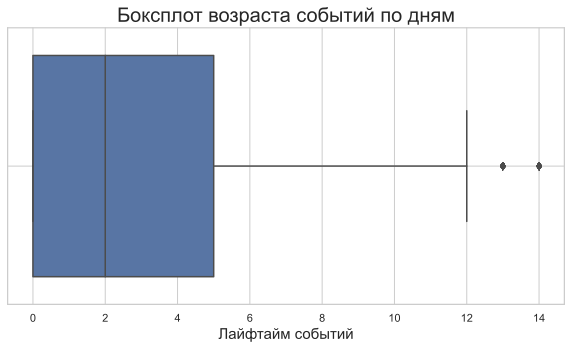

In [48]:
sns.boxplot(x=df['lifetime'], data=df)
plt.grid(True)
plt.title('Боксплот возраста событий по дням', fontsize=20)
plt.xlabel('Лайфтайм событий', fontsize=15)
plt.show();

In [49]:
df['lifetime'].quantile(0.95)

10.0

##### Вывод
По распределению и ящику с усами видно, что абсолютное большинство действий совершается до `12` лайфтайма, `95-ый` перцентиль равный 10му лайфтайму говорит о том, что 95% данных меньше или равно лайфтайму равному `10`, поэтому, можем сделать вывод, что можем игнорировать требование ТЗ про `14` лайфтайм. То есть, пользователю не обязательно жить `14` дней, у них есть возможность пройти ее раньше, поэтому, удалять пользователей, которые не прожили `14` дней мы не будем

### 3.6 Оценка влияния маркетингового события и динамики количества событий в группах теста по дням

In [50]:
# добавим столбец с чистой датой маретинг события
df['event_date'] =pd.to_datetime(df['event_dt']).dt.date

In [51]:
# построим таблицу с разбитием на группы
temp_table_a = df[(df['group'] == 'A')].groupby(['event_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_events_a'})
temp_table_b = df[(df['group'] == 'B')].groupby(['event_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_events_b'})
temp_table = temp_table_a.merge(temp_table_b, on='event_date', how='outer')
temp_table

,event_date,count_events_a,count_events_b
0,2020-12-07,263,315
1,2020-12-08,283,207
2,2020-12-09,331,289
3,2020-12-10,294,218
4,2020-12-11,309,137
5,2020-12-12,319,169
6,2020-12-13,273,122
7,2020-12-14,880,227
8,2020-12-15,915,187
9,2020-12-16,870,322


In [52]:
#построим таблицу распределения кол-ва событий
fig= go.Figure(data=[
    go.Bar(name='Группа A', x=temp_table['event_date'], y=temp_table['count_events_a']),
    go.Bar(name='Группа B', x=temp_table['event_date'], y=temp_table['count_events_b'])
])
fig.update_layout(barmode='group',
                  title='Распределение событий по дням по группам',
                  width=950,
                  height=700,
                  xaxis_title='Дата',
                  yaxis_title='Количество событий')
fig.add_vrect(x0='2020-12-25', x1='2021-01-03', 
              annotation_text="Christmas&New Year Promo", annotation_position="top right",
              fillcolor="red", opacity=0.25, line_width=0)

fig.show()

Видно, что в дни проведения акции активность пользователей уже пошла на спад, можно разглядеть тенденцию и так, но в силу того, что группы распределились не равномерно, то добавим в таблицу абсолютное значение совершенных событий в дату ко всем событиям в группе и построим этот же график снова: 

In [53]:
# добавим долевое отношение 
temp_table['ratio_a'] = temp_table['count_events_a'] / sum(temp_table['count_events_a'])*100
temp_table['ratio_b'] = temp_table['count_events_b'] / sum(temp_table['count_events_b'])*100


In [54]:
temp_table.head()

,event_date,count_events_a,count_events_b,ratio_a,ratio_b
0,2020-12-07,263,315,1.66,7.53
1,2020-12-08,283,207,1.79,4.95
2,2020-12-09,331,289,2.09,6.91
3,2020-12-10,294,218,1.85,5.21
4,2020-12-11,309,137,1.95,3.28


In [55]:
fig = go.Figure(data=[
    go.Bar(name='Группа A', x=temp_table['event_date'], y=temp_table['ratio_a']),
    go.Bar(name='Группа B', x=temp_table['event_date'], y=temp_table['ratio_b'])
])
fig.update_layout(barmode='group',
                  title='Доля событий по дням по группам в долях',
                  width=950,
                  height=700,
                  xaxis_title='Дата',
                  yaxis_title='Доля от своей группы, %')

fig.add_vrect(x0='2020-12-25', x1='2021-01-03', 
              annotation_text="Christmas&New Year Promo", annotation_position="top right",
              fillcolor="red", opacity=0.25, line_width=0)
fig.show()

#### Вывод 
Теперь можно быть на 100% уверенным, что в даты проведения маркетингового события наблюдался спад активности. Но, ко всему прочему, мы теперь можем сделать вывод, что у группы B наблюдается два пика активности, в начале и в середине теста, когда у группы A пик активности был только в середине теста


<div id="1" >



 - [Назад](#div_id1)

### 3.7 Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
* конверсии в просмотр карточек товаров — событие product_page
* просмотры корзины — product_cart
* покупки — purchase .


 Построим простую продуктовую воронку для сценария [`sign_up` - `login` - `product_page` - `product_cart` - `purchase`]

In [56]:
# собираем воронку пользователей группы А
users_count_a = df[df['group'] == "A"].groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).rename(columns={'user_id': 'user_count'})
first_step = pd.DataFrame(data = {'user_count': [df[df['group'] == 'A']['user_id'].unique().shape[0]]},
                          index=(['sign_up']))
users_count_a = pd.concat([users_count_a, first_step])


new_index = ['sign_up', 'login', 'product_page', 'product_cart', 'purchase']
users_count_a = users_count_a.reindex(new_index)
users_count_a['group'] = 'A'
users_count_a = users_count_a.reset_index().rename(columns={'index':'step'})
users_count_a

,step,user_count,group
0,sign_up,2279,A
1,login,2279,A
2,product_page,1476,A
3,product_cart,686,A
4,purchase,734,A


In [57]:
# собираем воронку пользователей группы В
users_count_b = df[df['group'] == "B"].groupby('event_name').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False).rename(columns={'user_id': 'user_count'})
first_step = pd.DataFrame(data = {'user_count': [df[df['group'] == 'B']['user_id'].unique().shape[0]]},
                          index=(['sign_up']))
users_count_b = pd.concat([users_count_b, first_step])


new_index = ['sign_up', 'login', 'product_page', 'product_cart', 'purchase']
users_count_b = users_count_b.reindex(new_index)
users_count_b['group'] = 'B'
users_count_b = users_count_b.reset_index().rename(columns={'index':'step'})
users_count_b

,step,user_count,group
0,sign_up,771,B
1,login,770,B
2,product_page,429,B
3,product_cart,214,B
4,purchase,219,B


In [58]:
fig = go.Figure()
fig.update_layout(title='Воронка `sign_up`-`login`-`product_page`-`product_cart`-`purchase`', title_x=0.5)
fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = users_count_a['step'],
    x = users_count_a['user_count'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    orientation = "h",
    y =  users_count_b['step'],
    x = users_count_b['user_count'],
    textposition = "inside",
    textinfo = "value+percent initial"))

fig.show()

#### Вывод 

Ожидаемый эффект изменения конверсии в продуктовой воронке экспериментальной группы по сравнению с контрольной не сбылся, конверсия, по интересующим нас этапам, на каждом шаге, в экспериментальной группе стала хуже, чем в контрольной

### Общий вывод
Проведя проверку на соответствие данных техническому заданию можно сделать выводы:
* Данные предоставлены не за весь срок проведения АБ теста
* Во время проведения АБ теста проходило маркетинговое событие, которое, могло повлиять на данные, но, изучив активность пользователей, мы решили, что маркетинговое событие не повлияло на пользователей
* Согласно ТЗ нам нужны были пользователи из EU и, исключительно, новые пользователи. В датафрейме участников теста были старые пользователи. Проверку на пользователей из других регионов мы не делали, заранее исключив таких пользователей 
* В датафрейме участников теста присутствовало пересечение пользователей по двум разным тестам, также пересекались пользователи по группам в рамках нужного теста. Данные почистили, пользователей из нашего теста, которые попали в контрольную группу конкурирующего теста сохранили, всех остальных удалили. Стоит отметить, что доля "грязных" очень велика - порядка `25%`
* Часть пользователей, участвовавших в тесте, после регистрации не совершила ни одного действия и их доля также велика - `29%` контрольной группы и `68%` экспериментальной 
* Согласно ТЗ нас интересовали пользователи, которые не были старше `14` дней, поэтому, мы удалили все события, лайфтайм которых был больше `14`
* По итогу, после всех операций по очистки данных у нас осталось `2279` уникальных пользователя контрольной группы и `771` уникальных пользователя экспериментальной группы
* Ожидаемый эффект: за `14` дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на `5` процентных пунктов не сбылся, конверсия экспериментальной группы хуже контрольной на всех этапах воронки
* Ожидаемое количество участников теста: `15% `новых пользователей из региона `EU` - сбылось 

* Представьте развернутый вывод о соответствии теста требованиям технического задания и возможности получения достоверных результатов АБ-теста, исходя из базового показателя конверсии в 50%. 
    - Калькулятор размера выборки: [https://www.evanmiller.org/ab-testing/sample-size.html] определяет минимальны размер выборки для определения относительного различия между группами теста в `5 процентных пунктов`, при базовой конверсии `50%`, мощности теста в `80%` и уровне значимости в `5%`  - `1567` наблюдений для каждой группы. Получается, что изначально тест был проведен с нарушениями. Группа `B` изначально сильно меньше минимального размера выборки, а группа `A`  на определенном этапе воронки тоже становится меньше минимального размера выборки. Достоверных результатов АБ-теста получить невозможно


    

## Шаг 4. Исследовательский анализ данных

### 4.1 Распределение количества событий на пользователя в разрезе групп теста: постройте гистограмму распределения этой величины в разрезе групп и сравните её средние значения между собой у групп теста;

In [59]:
#посчитаем для каждого юзера сколько дейсвтий он совершил
events_count_table = df.groupby(['user_id'])['event_name'].agg('count').reset_index().rename(columns={'event_name': 'events_count'})
events_count_table.head()

,user_id,events_count
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,005E096DBD379BCF,4


In [60]:
# добавим новый стобец в дафтрейм
df = df.merge(events_count_table, on='user_id')
df.head()

,user_id,first_date,region,device,group,ab_test,event_dt,event_name,details,lifetime,event_date,events_count
0,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:10,product_page,NaN,0,2020-12-07,2
1,D72A72121175D8BE,2020-12-07,EU,PC,A,recommender_system_test,2020-12-07 21:52:07,login,NaN,0,2020-12-07,2
2,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-07 15:32:54,product_page,NaN,0,2020-12-07,10
3,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-08 08:29:31,product_page,NaN,1,2020-12-08,10
4,DD4352CDCF8C3D57,2020-12-07,EU,Android,B,recommender_system_test,2020-12-10 18:18:27,product_page,NaN,3,2020-12-10,10


In [61]:
# соберем табличку для графика
temp_table = df.drop_duplicates(subset=['user_id', 'events_count']).groupby(['events_count', 'group'])['user_id'].count().reset_index()
temp_table.head()

,events_count,group,user_id
0,1,A,28
1,1,B,20
2,2,A,173
3,2,B,102
4,3,A,204


In [62]:
fig = go.Figure(data=[
    go.Bar(name='Группа A', x=temp_table[temp_table['group']=='A']['events_count'], y=temp_table[temp_table['group']=='A']['user_id']),
    go.Bar(name='Группа B', x=temp_table[temp_table['group']=='B']['events_count'], y=temp_table[temp_table['group']=='B']['user_id'])
])
fig.update_layout(barmode='group',
                  title='Распределение количества событий на пользователя в разрезе групп теста',
                  width=950,
                  height=700,
                  xaxis_title='Количество событий на пользователя',
                  yaxis_title='Количество пользователей')

fig.show()

In [63]:
df.drop_duplicates(subset=['user_id', 'events_count']).groupby('group')['events_count'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
A,2279.00,6.96,3.85,1.00,4.00,6.00,9.00,24.00
B,771.00,5.43,3.25,1.00,3.00,4.00,7.00,24.00


#### Вывод 
Пользователи группы А совершают больше действий, чем пользователи группы B, при чем, среднеарифметический и медианный показатель разнится почти в полтора раза

### 4.2 Динамика количества событий в группах теста по дням: изучите распределение числа событий по дням и сравните динамику групп теста между собой.

<div id="div_id1">


- Этот блок описан в пункте 3.6 [⬆ тут](#1)

### 4.3 Оценка динамики регистрации

In [64]:
# разобьем на группы 
temp_table_a = df[(df['group'] == 'A')].groupby(['first_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_user_a'})
temp_table_b = df[(df['group'] == 'B')].groupby(['first_date'])['user_id'].agg('count').reset_index().rename(columns={'user_id': 'count_user_b'})
temp_table = temp_table_a.merge(temp_table_b, on='first_date', how='outer')
temp_table

,first_date,count_user_a,count_user_b
0,2020-12-07,794,987
1,2020-12-08,525,188
2,2020-12-09,471,374
3,2020-12-10,253,129
4,2020-12-11,443,63
5,2020-12-12,273,220
6,2020-12-13,205,36
7,2020-12-14,2539,301
8,2020-12-15,1396,123
9,2020-12-16,1047,612


In [65]:
fig = go.Figure(data=[
    go.Bar(name='Группа A', x=temp_table['first_date'], y=temp_table['count_user_a']),
    go.Bar(name='Группа B', x=temp_table['first_date'], y=temp_table['count_user_b'])
])
fig.update_layout(barmode='group',
                  title='Распределение регистраций пользователей без действий по дням по группам',
                  width=950,
                  height=700,
                  xaxis_title='Дата',
                  yaxis_title='Количество регистраций')
fig.show()

На мой взгляд, по этому графику трудно оценить динамику, нужно смотреть в абсолютном отношении:

In [66]:
# добавим долевое отношение 
temp_table['ratio_a'] = temp_table['count_user_a'] / sum(temp_table['count_user_a'])*100
temp_table['ratio_b'] = temp_table['count_user_b'] / sum(temp_table['count_user_b'])*100

In [67]:
fig = go.Figure(data=[
    go.Bar(name='Группа A', x=temp_table['first_date'], y=temp_table['ratio_a']),
    go.Bar(name='Группа B', x=temp_table['first_date'], y=temp_table['ratio_b'])
])
fig.update_layout(barmode='group',
                  title='Распределение регистраций пользователей по дням по группам в долях',
                  width=950,
                  height=700,
                  xaxis_title='Дата',
                  yaxis_title='Доля от своей группы, %')
fig.show()

##### Вывод 
По распределению по долям видно, что в первые дни теста пришла весомая доля пользователей их группы `B`, а пользователи группы `А` зарегистрировались уже во второй половине теста

### Общий вывод по блоку

Проведя исследовательский анализ данных, изучив распределения событий, динамику событий, динамику регистрации пользователей можно сделать вывод, что: 
* данные распределены не равномерно 
* набор пользователей проводился в разные дни
* среднеарифметические и медианные показатели количества событий на пользователя у группы `A` в полтора раза больше, чем у группы `B`



## Шаг 5. Проведите оценку результатов A/B-тестирования:
Проверьте статистическую разницу долей z-критерием. Что можно сказать про результаты A/B-тестирования? Был ли достигнут ожидаемый эффект в изменении конверсии?

Проверим статистическую разницу долей z-критерием на каждом этапе воронки, кропе `sign_up`
Нулевая гипотеза (H0): конверсия в следующий этап воронки у группа `А` и у группы `B` - одинаковые

Альтернативная гипотеза (H1): конверсия в следующий этап воронки у группа `А` и у группы `B` - разные

In [68]:
def z_test(successesA, successesB, trialsA, trialsB, alpha=0.05):
    p1 = successesA / trialsA
    p2 = successesB / trialsB

    p_combined = (successesA + successesB) / (trialsA + trialsB)
    difference = p1 - p2

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trialsA + 1/trialsB))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)

    if (p_value < alpha):
        display('Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия')
    else:
        display('Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет')

In [69]:
#login

z_test(successesA=df[(df['group']=='A') & (df['event_name']=='login')]['user_id'].unique().shape[0],
       successesB=df[(df['group']=='B') & (df['event_name']=='login')]['user_id'].unique().shape[0],
       trialsA=df[df['group']=='A']['user_id'].unique().shape[0], 
       trialsB=df[df['group']=='B']['user_id'].unique().shape[0], 
       alpha=0.05)

print('Конверсия в этап login воронки группы пользователей А: {:.2f}%'.format(
    df[(df['group']=='A') & (df['event_name']=='login')]['user_id'].unique().shape[0] / 
    df[df['group']=='A']['user_id'].unique().shape[0]*100))

print('Конверсия в этап login воронки группы пользователей B: {:.2f}%'.format(
    df[(df['group']=='B') & (df['event_name']=='login')]['user_id'].unique().shape[0] /
    df[df['group']=='B']['user_id'].unique().shape[0]*100))

p-значение:  0.08551328290029048


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

Конверсия в этап login воронки группы пользователей А: 100.00%
Конверсия в этап login воронки группы пользователей B: 99.87%


In [70]:
#product_page

z_test(successesA=df[(df['group']=='A') & (df['event_name']=='product_page')]['user_id'].unique().shape[0],
       successesB=df[(df['group']=='B') & (df['event_name']=='product_page')]['user_id'].unique().shape[0],
       trialsA=df[df['group']=='A']['user_id'].unique().shape[0], 
       trialsB=df[df['group']=='B']['user_id'].unique().shape[0], 
       alpha=0.05)

print('Конверсия в этап product_page воронки группы пользователей А: {:.2f}%'.format(
    df[(df['group']=='A') & (df['event_name']=='product_page')]['user_id'].unique().shape[0] / 
    df[df['group']=='A']['user_id'].unique().shape[0]*100))

print('Конверсия в этап product_page воронки группы пользователей B: {:.2f}%'.format(
    df[(df['group']=='B') & (df['event_name']=='product_page')]['user_id'].unique().shape[0] /
    df[df['group']=='B']['user_id'].unique().shape[0]*100))

p-значение:  6.120730626113513e-06


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

Конверсия в этап product_page воронки группы пользователей А: 64.77%
Конверсия в этап product_page воронки группы пользователей B: 55.64%


In [71]:
#product_cart
z_test(successesA=df[(df['group']=='A') & (df['event_name']=='product_cart')]['user_id'].unique().shape[0],
       successesB=df[(df['group']=='B') & (df['event_name']=='product_cart')]['user_id'].unique().shape[0],
       trialsA=df[df['group']=='A']['user_id'].unique().shape[0], 
       trialsB=df[df['group']=='B']['user_id'].unique().shape[0], 
       alpha=0.05)

print('Конверсия в этап product_cart воронки группы пользователей А: {:.2f}%'.format(
    df[(df['group']=='A') & (df['event_name']=='product_cart')]['user_id'].unique().shape[0] / 
    df[df['group']=='A']['user_id'].unique().shape[0]*100))

print('Конверсия в этап product_cart воронки группы пользователей B: {:.2f}%'.format(
    df[(df['group']=='B') & (df['event_name']=='product_cart')]['user_id'].unique().shape[0] /
    df[df['group']=='B']['user_id'].unique().shape[0]*100))

p-значение:  0.21721122664962245


'Не получилось отвергнуть нулевую гипотезу, статистически значимых различий в выборках нет'

Конверсия в этап product_cart воронки группы пользователей А: 30.10%
Конверсия в этап product_cart воронки группы пользователей B: 27.76%


In [72]:
#purchase
z_test(successesA=df[(df['group']=='A') & (df['event_name']=='purchase')]['user_id'].unique().shape[0],
       successesB=df[(df['group']=='B') & (df['event_name']=='purchase')]['user_id'].unique().shape[0],
       trialsA=df[df['group']=='A']['user_id'].unique().shape[0], 
       trialsB=df[df['group']=='B']['user_id'].unique().shape[0], 
       alpha=0.05)

print('Конверсия в этап purchase воронки группы пользователей А: {:.2f}%'.format(
    df[(df['group']=='A') & (df['event_name']=='purchase')]['user_id'].unique().shape[0] / 
    df[df['group']=='A']['user_id'].unique().shape[0]*100))

print('Конверсия в этап purchase воронки группы пользователей B: {:.2f}%'.format(
    df[(df['group']=='B') & (df['event_name']=='purchase')]['user_id'].unique().shape[0] /
    df[df['group']=='B']['user_id'].unique().shape[0]*100))

p-значение:  0.048942596376941205


'Отвергаем нулевую гипотезу, между выборками есть статистически значимые различия'

Конверсия в этап purchase воронки группы пользователей А: 32.21%
Конверсия в этап purchase воронки группы пользователей B: 28.40%


## Вывод
По итогу, проведя проверку на соответствие данных техническому заданию, исследовательский анализ данных и оценку результатов АБ тестирования можно сделать выводы, что тест был проведен с нарушениями:

* даты набора участников для теста в разные группы распределен неравномерно 

* группы разные по количеству участников 
* в датафрейме участников были перемешаны новые и старые пользователи 
* в даты проведения теста проходило маркетинговое событие, которое могло повлиять на результаты
* большая доля пользователей не совершило ни одного действия, наблюдается сдвиг в одну из групп
* данные для оценки результатов не соответствуют периоду, в который проходил тест
* по факту очистки данных у нас осталось `2279` уникальных пользователя контрольной группы и `771` уникальных пользователя экспериментальной группы
* стоит отметить, что ожидаемое количество участников теста: `15% `новых пользователей из региона `EU` - сбылось 
* при этом, ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов не сбылся, конверсия экспериментальной группы хуже контрольной на всех этапах воронки, но учитывая все нарушения при проведении теста и неполноты данных при оценке результатов АБ тестирования - сделать 100% выводы о том, что `recommender_system_test` увеличивает или уменьшает конверсию `нельзя`
* нет разницы в выборках только на этапе `product_cart`, отсутствие  различий на этапе `login` возможно, обусловлено тем, что удалялись пользователи без действий

Все эти выводы наводят на мысль, что для того, чтобы вынести какой-то вердикт `recommender_system_test` нужно провести тест заново, избегая все допущенные ошибки раннее.
